## Scikit Learn pipeline

In [12]:
## Setting to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [13]:
## Imports
## General utils
import pandas as pd
import numpy as np
import seaborn as sns

## Transformers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
## Classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
## Model selection and Pipeline utils
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix


## Text processing libraries
import re
from nltk.corpus import stopwords
import emoji
import contractions ## from here: https://github.com/kootenpv/contractions

from pprint import pprint
from time import time
import logging

### Read Data
1. Drop duplicate reviews
2. Drop unused columns
3. Create column for review length
4. Drop unusually long reviews

In [14]:
## Read data and copy
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
data_in = spotify.copy()
data_in = data_in.drop_duplicates(subset="Review")
data_in.drop(["Time_submitted", "Total_thumbsup", "Reply"], axis=1, inplace=True)
data_in["Length"] = data_in["Review"].str.split(" ").str.len()
data_in = data_in[data_in.Length < 150]
data = data_in

### Code Sentiment
* Ratings 1, 2 and 3 as _negative_
* Ratings 4 and 5 as _positive_

In [15]:
## Code sentiment from rating (1 or 2 == bad, 3 == neutral, 4 or 5 == good)
def get_sentiment(rating):
    if rating == 1 or rating == 2 or rating == 3:
        return "negative"
    # if rating == 3:
    #     return "neutral"
    if rating == 4 or rating == 5:
        return "positive"

data["Sentiment"] = data["Rating"].apply(get_sentiment)


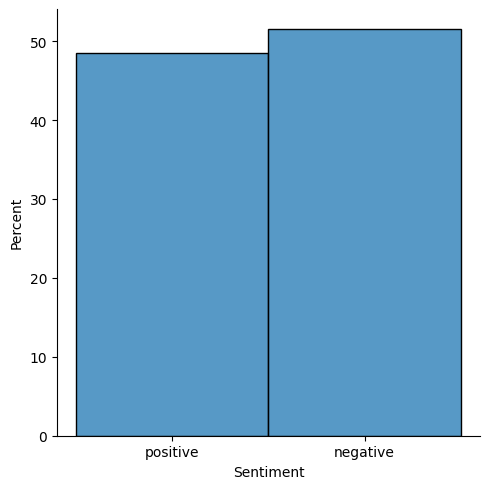

In [16]:
## Plot sentiment distribution
ax = sns.displot(data=data, x='Sentiment', stat='percent');

### Define Stopwords
Here we grab the NLTK stopwords but want to keep "not" 

In [17]:
our_stop_words = set(stopwords.words('english'))
our_stop_words.remove("not")

### Translate emojis to text
We use this function here to translate emojis to text. We will need this function later on to include in our prediction pipeline, so that new data will be transformed in the same way.

In [18]:
## define a function to translate emojis text
def translate_emoji(sentence):
  return emoji.demojize(sentence)

In [19]:
data["Review"] = data["Review"].apply(translate_emoji)

### Translate contractions

Change contractions like _I'm_, _they're_ etc. to _I am_, _they are_ etc. We'll use this again later in our prediction pipeline.

In [20]:
def translate_contractions(sentence):
    return contractions.fix(sentence)

In [21]:
data["Review"] = data["Review"].apply(translate_contractions)

### Remove strange fonts
There are some strange unreadable fonts like 𝚝𝚑𝚒𝚜 in the reviews. Here we remove them. Again, we'll use this function later in our make_prediction function.

In [22]:
def remove_strange_fonts(sentence):
    return re.sub(r'[^\x00-\x7f]', r'', sentence)


data['Review'] = data['Review'].apply(lambda sentence: list(map(remove_strange_fonts, sentence)))
data["Review"] = data["Review"].apply(lambda sentence: "".join(sentence))

In [23]:
data["Review"]

0        Great music service, the audio is high quality...
1        Please ignore previous negative rating. This a...
2        This pop-up "Get the best Spotify experience o...
3          Really buggy and terrible to use as of recently
4        Dear Spotify why do I get songs that I did not...
                               ...                        
61589    Even though it was communicated that lyrics fe...
61590    Use to be sooo good back when I had it, and wh...
61591    This app would be good if not for it taking ov...
61592    The app is good hard to navigate and will not ...
61593    Its good but sometimes it does not load the mu...
Name: Review, Length: 61346, dtype: object

### Create features and target and split into training, development and test set

In [24]:
X = data["Review"]
y = data["Sentiment"]
print("Shape of X and y: ", X.shape, y.shape)

Shape of X and y:  (61346,) (61346,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36807,) (24539,) (36807,) (24539,)


In [26]:
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, random_state=42)
print(X_dev.shape, X_test.shape, y_dev.shape, y_test.shape)

(12269,) (12270,) (12269,) (12270,)


### Create Pipeline for hyperparameter selection

Here we define all the parameters we want to combine later on in our Grid Search to find the best combination and hence model.

In [27]:
## define parameters for the pipelines

## Parameters for Feature extraction
transformer_parameters = {
    'vect__max_features': (None, 5000, 10000),
    "vect__ngram_range": ((1, 1), (1, 2), (1,3)),  # unigrams or bigrams
    'tfidf__norm': ('l1','l2')
}

## Parameters for classifiers
logistic_regression_parameters = {
        'clf': (LogisticRegression(
            fit_intercept=True,
            class_weight=None,
            max_iter=1000,
            random_state=42),
            ),
        'clf__penalty': ("none","l1","l2","elasticnet"),
        'clf__solver': ('lbfgs', 'sag'),
        'clf__C': (0.01, 0.1, 1, 10, 100),
        "clf__l1_ratio": (0.01, 0.1,1)
    }

svc_parameters = {
        'clf': (SVC(
            probability=True,
            tol=1e-3,
            class_weight=None,
            max_iter=1000,
            random_state=42),
            ),
        'clf__kernel': ("linear","poly","rbf","sigmoid"),
        'clf__C': (0.001, 0.01, 0.1, 1, 10, 100),
        "clf__gamma": (0.001, 0.01, 0.1, 1, 10, 100, "scale"),
        "clf__shrinking": (True, False),
        "clf__decision_function_shape": ("ovr", "ovo")
    }

rf_parameters = {
        'clf': (RandomForestClassifier(
            criterion="gini",
            min_samples_leaf=5,
            oob_score=True,
            class_weight=None,
            random_state=42),
            ),
        'clf__n_estimators': (10, 100, 1000),
        'clf__max_depth': (3, 5, 10, 50, 100, None),
        #"clf__min_samples_split": (2, 5, 10),
        #"clf__max_features": ("sqrt", "log2"),
        #"clf__bootstrap": (True, False)
    }

In [28]:
## Combine the parameter sets; this will be the one we actually pass to the function
logistic_parameters = [
    transformer_parameters,
    logistic_regression_parameters
]

svc_parameters = [
    transformer_parameters,
    svc_parameters
]

random_forest_parameters = [
    transformer_parameters,
    rf_parameters
]

In the cell below, a lot is happening. First, we create a list that contains all the parameter sets for the different classifiers, and a list that contains all the classifiers. In the loop, the zip function zips those two lists together, and passes the first parameter set and the first classifier to the pipeline and to GridSearchCV. The Grid Search then fits a model for every parameter combination (times the number of cross validation folds).

Note 1: The loop stores only the last model.
Note 2: Parameter combinations can become legion very quickly. With only the parameters for logistic regression and the parameters for our count and tfidf vecotrizer, it amounts to 138 combinations time 3 folds from CV, totalling 414 models that need to be fit.

In [29]:
## This takes a VERY long time to run
#all_parameter_sets = [logistic_parameters, svc_parameters, rf_parameters]
#classifiers = [LogisticRegression(), SVC(), RandomForestClassifier()]

## "Loop" only through log regression, this takes about 5 minutes on a reasonable machine.
all_parameter_sets = [logistic_parameters]
classifiers = [LogisticRegression()]

for parameter_sets, classifier in zip(all_parameter_sets, classifiers):
    #define pipeline
    pipeline = Pipeline(
        [   
            ("vect", CountVectorizer(stop_words=our_stop_words)),
            ("tfidf", TfidfTransformer()),
            ("clf", classifier)
        ]
    )
    ## Perform grid search CV
    print("Fitting ", str(classifier)[:-2]+" Classifier")
    gs = GridSearchCV(pipeline, parameter_sets, n_jobs=-1, verbose=1, scoring="accuracy", cv = 3) ## NOTE: -1 means all processors

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameter_sets)

    gs.fit(X_train, y_train)
    
    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters set:")

    best_parameters = gs.best_estimator_.get_params()

    for parameter_set in parameter_sets:
        for param_name in sorted(parameter_set.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

    print("----------------------")

Fitting  LogisticRegression Classifier
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
[{'tfidf__norm': ('l1', 'l2'),
  'vect__max_features': (None, 5000, 10000),
  'vect__ngram_range': ((1, 1), (1, 2), (1, 3))},
 {'clf': (LogisticRegression(max_iter=1000, random_state=42),),
  'clf__C': (0.01, 0.1, 1, 10, 100),
  'clf__l1_ratio': (0.01, 0.1, 1),
  'clf__penalty': ('none', 'l1', 'l2', 'elasticnet'),
  'clf__solver': ('lbfgs', 'sag')}]
Fitting 3 folds for each of 138 candidates, totalling 414 fits
Best score: 0.875
Best parameters set:
	tfidf__norm: 'l2'
	vect__max_features: 10000
	vect__ngram_range: (1, 2)
	clf: LogisticRegression()
	clf__C: 1.0
	clf__l1_ratio: None
	clf__penalty: 'l2'
	clf__solver: 'lbfgs'
----------------------


We see that the best model with given parameter combination scored at %, let's dig a bit deeper into the results.

### Investigate model scores

In [30]:
our_classifier =  gs.best_estimator_
predictions = our_classifier.predict(X_dev)

We see below that the model overfitted a bit, since accuracy is quite a bit higher on the training compared to the unseen dev set. We also see, that the cross validation score (that is, the average accuracy score across three CV folds) is much closer to the score of the unseen dev set, showing the true power of CV: That you get a way better estimate of how your model will perform on unseen data. And this with just one data set!

In [31]:
print("Accuracy on training set: %0.3f" % our_classifier.score(X_train, y_train))
print("Accuracy on development set: %0.3f" % our_classifier.score(X_dev, y_dev))

Accuracy on training set: 0.901
Accuracy on development set: 0.876


Accuracy is a nice measure to start off with but can be far from optimal and even misleading, especially when dealing with class imbalance (if you have only 10% negative reviews then a classifier classifying everything as positive will be 90% accurate). But there's other ways to judge whether your model performed well or not.

Here we see a __confusion matrix__, showing the counts of True/False Positive/Negative.

In [32]:
confusion_matrix(y_dev, predictions, labels=["positive", "negative"])

array([[4995,  957],
       [ 565, 5752]], dtype=int64)

__Precision and Recall__, as well as their combination into an __F1 score__, are some of the most widely used metrics to judge a model's performance. See [here](https://www.researchgate.net/figure/Calculation-of-Precision-Recall-and-Accuracy-in-the-confusion-matrix_fig3_336402347) how they are calculated.

In [33]:
print(classification_report(y_dev, predictions))

              precision    recall  f1-score   support

    negative       0.86      0.91      0.88      6317
    positive       0.90      0.84      0.87      5952

    accuracy                           0.88     12269
   macro avg       0.88      0.87      0.88     12269
weighted avg       0.88      0.88      0.88     12269



This is a really nice accuracy score for predicting labels users have given. LEt's move on to use the model to make predictions on unseen data.

### Make predictions

Here we define a function that runs through our pipeline: It translates emojis into readable strings, translate contractions, and removes strange fonts. Onyl then it's passed into the sklearn vectorizers which are part of the pipeline in our model now.

In [63]:
def make_prediction(classifier, sentence):
    temp = translate_emoji(sentence)
    temp = translate_contractions(temp)
    temp = remove_strange_fonts(temp)
    print("This review is:", classifier.predict([temp])[0])


In [66]:
review = "I  ❤️ Spotify, even though it sucks"

make_prediction(our_classifier, review)

## Well...

This review is: positive


In [67]:
review = "I hate Spotify"

make_prediction(our_classifier, review)

This review is: negative
